In [2]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from src.datasets import load_dataset, preprocess_dataset, prefetch_dataset
from src.utils import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
cfg = { 'dataset' : 'svhn',
        'model' : 'densenet121',
        'batch_size' : 512,
        'optimizer' : 'Adam',
        'learning_rate' : 0.001,
        'max_epoch' : 300,
        'patience' : 10,}    

model_name = cfg['model']
dataset_name = cfg['dataset']

### Softmax

In [ ]:
n_examples = [int(i/1000*10000) for i in range(0,11,2)] + [int(i/100*10000) for i in range(2,10,2)] + [int(i/10*10000) for i in range(1,10,2)]

for run in range(5):
    tf.keras.utils.set_random_seed(run+10) # set random seed for Python, NumPy, and TensorFlow
    print(f'Run: {run+1}')
    
    ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
    n_classes = ds_info.features['label'].num_classes
    ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
    
    model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
    n_wrong = (1 - model.evaluate(ds_test.batch(cfg['batch_size']), verbose=0)[1])*len(ds_test)
    preds = model.predict(ds_test.batch(cfg['batch_size']), verbose=0)
    true_y = np.argmax([y for x,y in ds_test], axis=1)
    pred_y = np.argmax(preds, axis=1)
    true_label = np.equal(true_y, pred_y).astype(int) # assign 0 if true_y != pred_y, assign 1 if true_y == pred_y
    softmax_val = np.max(preds, axis=1)

    softmax_error_list = []
    for n in n_examples:
        err = 1 - compute_selective_pred_acc(softmax_val, ds_test, model, n)
        softmax_error_list.append(err)
    
    softmax_error = np.array(softmax_error_list)

    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
    np.savez(f'{exp_name}/softmax_selective_pred.npz', softmax=softmax_error, n_wrong=n_wrong)

In [32]:
acc = []
n = []
for run in range(5):
    tf.keras.utils.set_random_seed(run+10) # set random seed for Python, NumPy, and TensorFlow
    print(f'Run: {run+1}')
    
    ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
    n_classes = ds_info.features['label'].num_classes
    ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=True, normalize=True, onehot=True)
    
    model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
    temp = np.load(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/opt_temp.npy')
    logits_layer = model.layers[-1]
    logits_layer.activation = None 
    logits_model = tf.keras.models.Model(inputs=model.input, outputs=logits_layer.output)
    preds = logits_model.predict(ds_test.batch(cfg['batch_size']), verbose=0)
    preds = np.array([softmax(x/temp) for x in preds])
    softmax_val = np.max(preds, axis=1)
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
    f = np.load(f'{exp_name}/calibrated_softmax_filtering_accuracy.npz')
    opt_threshold = f['opt_threshold']
    idx = np.where(softmax_val > opt_threshold)[0]
    x = np.array([x for x, y in ds_test])
    y = np.array([y for x, y in ds_test])
    acc.append(model.evaluate(x[idx], y[idx], verbose=0)[1])
    n.append(len(idx))

Run: 1


FileNotFoundError: [Errno 2] No such file or directory: '../results/PI_Explainability/pretrained_inception_stl10/run_1/opt_temp.npy'

In [53]:
acc = []
n = []
for run in range(5):
    tf.keras.utils.set_random_seed(run+10) # set random seed for Python, NumPy, and TensorFlow
    print(f'Run: {run+1}')
    
    ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
    n_classes = ds_info.features['label'].num_classes
    ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
    
    model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
    preds = model.predict(ds_test.batch(cfg['batch_size']), verbose=0)
    preds = np.array([softmax(x) for x in preds])
    softmax_val = np.max(preds, axis=1)
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
    f = np.load(f'{exp_name}/softmax_filtering_accuracy.npz')
    opt_threshold = f['opt_threshold']
    idx = np.where(softmax_val > opt_threshold)[0]
    x = np.array([x for x, y in ds_test])
    y = np.array([y for x, y in ds_test])
    acc.append(model.evaluate(x[idx], y[idx], verbose=0)[1])
    n.append(len(idx))

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5


In [54]:
print(f"Error: {100-np.mean(acc)*100:.2f} ({np.std(acc)*100:.2f}), n={(10000-int(np.mean(n)))/10000}")

Error: 4.68 (0.61), n=-1.5189


### PMI

In [ ]:
critic = 'separable'
estimator = 'density_ratio_fitting'

n_examples = [int(i/1000*10000) for i in range(0,11,2)] + [int(i/100*10000) for i in range(2,10,2)] + [int(i/10*10000) for i in range(1,10,2)]

for run in range(5):
    tf.keras.utils.set_random_seed(run+10) # set random seed for Python, NumPy, and TensorFlow
    print(f'Run: {run+1}')
    
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pmi/{critic}_{estimator}'
    ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
    n_classes = ds_info.features['label'].num_classes
    ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)

    model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
    pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)
    pmi_class = np.load(f'{exp_name}/pmi_class_test.npy')
    pmi_class = np.array([softmax(x) for x in pmi_class])
    pmi = [pmi_value[pred_value] for pmi_value, pred_value in zip(pmi_class, pred_y)]

    pmi_error_list = []
    for n in n_examples:
        err = 1 - compute_selective_pred_acc(pmi, ds_test, model, n)
        pmi_error_list.append(err)
    
    pmi_error = np.array(pmi_error_list)

    np.save(f'{exp_name}/selective_pred.npy', pmi_error)

In [50]:
critic = 'separable'
estimator = 'density_ratio_fitting'

acc = []
n = []
for run in range(5):
    tf.keras.utils.set_random_seed(run+10) # set random seed for Python, NumPy, and TensorFlow
    print(f'Run: {run+1}')
    
    ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
    n_classes = ds_info.features['label'].num_classes
    ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
    
    model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
    pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pmi/{critic}_{estimator}'
    pmi_class = np.load(f'{exp_name}/pmi_class_test.npy')
    pmi_class = np.array([softmax(x) for x in pmi_class])
    pmi = [pmi_value[pred_value] for pmi_value, pred_value in zip(pmi_class, pred_y)]
    f = np.load(f'{exp_name}/scaled_filtering_accuracy.npz')
    opt_threshold = f['opt_threshold']
    idx = np.where(pmi > opt_threshold)[0]
    x = np.array([x for x, y in ds_test])
    y = np.array([y for x, y in ds_test])
    acc.append(model.evaluate(x[idx], y[idx], verbose=0)[1])
    n.append(len(idx))

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5


In [51]:
print(f"Error: {100-np.mean(acc)*100:.2f} ({np.std(acc)*100:.2f}), n={(10000-int(np.mean(n)))/10000}")

Error: 4.24 (0.59), n=-1.5065


### PVI

In [ ]:
estimator = 'ensemble_training_from_scratch_training_mlp_penultimate'

n_examples = [int(i/1000*10000) for i in range(0,11,2)] + [int(i/100*10000) for i in range(2,10,2)] + [int(i/10*10000) for i in range(1,10,2)]

for run in range(5):
    tf.keras.utils.set_random_seed(run+10) # set random seed for Python, NumPy, and TensorFlow
    print(f'Run: {run+1}')
    
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pvi/{estimator}'
    ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
    n_classes = ds_info.features['label'].num_classes
    ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)

    model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
    pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)
    pvi_class = np.load(f'{exp_name}/pvi_class_test.npy')
    pvi_class = np.array([softmax(x) for x in pvi_class])
    pvi = [pmi_value[pred_value] for pmi_value, pred_value in zip(pvi_class, pred_y)]

    pvi_error_list = []
    for n in n_examples:
        err = 1 - compute_selective_pred_acc(pvi, ds_test, model, n)
        pvi_error_list.append(err)
    
    pvi_error = np.array(pvi_error_list)

    np.save(f'{exp_name}/selective_pred.npy', pvi_error)

In [36]:
estimator = 'training_from_scratch'

acc = []
n = []
for run in range(5):
    tf.keras.utils.set_random_seed(run+10) # set random seed for Python, NumPy, and TensorFlow
    print(f'Run: {run+1}')
    
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pvi/{estimator}'
    ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
    n_classes = ds_info.features['label'].num_classes
    ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=True, normalize=True, onehot=True)
    
    model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
    pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)
    pvi_class = np.load(f'{exp_name}/pvi_calibrated_class_test.npy')
    pvi_class = np.array([softmax(x) for x in pvi_class])
    pvi = [pvi_value[pred_value] for pvi_value, pred_value in zip(pvi_class, pred_y)]
    
    f = np.load(f'{exp_name}/calibrated_scaled_filtering_accuracy.npz')
    opt_threshold = f['opt_threshold']
    idx = np.where(pvi > opt_threshold)[0]
    x = np.array([x for x, y in ds_test])
    y = np.array([y for x, y in ds_test])
    acc.append(model.evaluate(x[idx], y[idx], verbose=0)[1])
    n.append(len(idx))

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5


In [37]:
print(f"Error: {100-np.mean(acc)*100:.2f} ({np.std(acc)*100:.2f}), n={(10000-int(np.mean(n)))/10000}")

Error: 3.95 (0.44), n=0.2108


### PSI

In [3]:
estimator = 'gaussian'

n_examples = [int(i/1000*10000) for i in range(0,11,2)] + [int(i/100*10000) for i in range(2,10,2)] + [int(i/10*10000) for i in range(1,10,2)]

for run in range(5):
    tf.keras.utils.set_random_seed(run+10) # set random seed for Python, NumPy, and TensorFlow
    print(f'Run: {run+1}')
    
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/psi/{estimator}'
    ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
    n_classes = ds_info.features['label'].num_classes
    ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)

    model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
    pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)
    psi_class = np.load(f'{exp_name}/psi_class_test.npy')
    psi_class = np.array([softmax(x) for x in psi_class])
    psi = [psi_value[pred_value] for psi_value, pred_value in zip(psi_class, pred_y)]

    psi_error_list = []
    for n in n_examples:
        err = 1 - compute_selective_pred_acc(psi, ds_test, model, n)
        psi_error_list.append(err)
    
    psi_error = np.array(psi_error_list)

    np.save(f'{exp_name}/selective_pred.npy', psi_error)

Run: 1


2024-02-02 11:03:31.343971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78835 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-02-02 11:03:38.122677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906


Run: 2
Run: 3
Run: 4
Run: 5


In [55]:
estimator = 'gaussian'

acc = []
n = []
for run in range(5):
    tf.keras.utils.set_random_seed(run+10) # set random seed for Python, NumPy, and TensorFlow
    print(f'Run: {run+1}')
    
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/psi/{estimator}'
    ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
    n_classes = ds_info.features['label'].num_classes
    ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
    
    model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
    pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)
    psi_class = np.load(f'{exp_name}/psi_class_test.npy')
    psi_class = np.array([softmax(x) for x in psi_class])
    psi = [psi_value[pred_value] for psi_value, pred_value in zip(psi_class, pred_y)]
    
    f = np.load(f'{exp_name}/scaled_filtering_accuracy.npz')
    opt_threshold = f['opt_threshold']
    idx = np.where(psi > opt_threshold)[0]
    x = np.array([x for x, y in ds_test])
    y = np.array([y for x, y in ds_test])
    acc.append(model.evaluate(x[idx], y[idx], verbose=0)[1])
    n.append(len(idx))

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5


In [56]:
print(f"Error: {100-np.mean(acc)*100:.2f} ({np.std(acc)*100:.2f}), n={(10000-int(np.mean(n)))/10000}")

Error: 4.74 (0.41), n=-1.5227


### Plot

In [13]:
all_softmax = []
all_n_wrong = []
all_pmi = []
all_pvi = []
all_psi = []

for run in range(5):
    print(f'Run: {run+1}')
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
    f = np.load(f'{exp_name}/softmax_selective_pred.npz')
    softmax = f['softmax']
    n_wrong = f['n_wrong']
    all_softmax.append(softmax)
    all_n_wrong.append(n_wrong)
    
    critic = 'separable'
    estimator = 'density_ratio_fitting'
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pmi/{critic}_{estimator}'
    pmi = np.load(f'{exp_name}/selective_pred.npy')
    all_pmi.append(pmi)
    
    estimator = 'ensemble_training_from_scratch_training_mlp_penultimate'
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pvi/{estimator}'
    pvi = np.load(f'{exp_name}/selective_pred.npy')
    all_pvi.append(pvi)
    
    estimator = 'gaussian'
    exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/psi/{estimator}'
    psi = np.load(f'{exp_name}/selective_pred.npy')
    all_psi.append(psi)
    
softmax_val = np.mean(np.array(all_softmax), axis=0)
n_wrong = int(np.mean(np.array(all_n_wrong), axis=0))
pmi = np.mean(np.array(all_pmi), axis=0)
pvi = np.mean(np.array(all_pvi), axis=0)
psi = np.mean(np.array(all_psi), axis=0)

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5


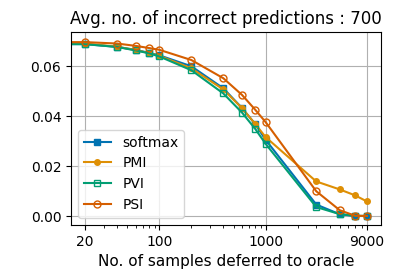

In [14]:
plt.figure(figsize=(4,2.5),dpi=100)
cp = sns.color_palette('colorblind', as_cmap=True)
length_test = 10000
n_examples = [int(i/1000*length_test) for i in range(0,11,2)] + [int(i/100*length_test) for i in range(2,10,2)] + [int(i/10*length_test) for i in range(1,10,2)]
plt.plot(n_examples,softmax_val, marker='s', label='softmax', c=cp[0], ms=4)
plt.plot(n_examples,pmi, marker='o', label='PMI', c=cp[1], ms=4)
plt.plot(n_examples,pvi, marker='s', label='PVI', c=cp[2], ms=5,  markerfacecolor="None")
plt.plot(n_examples,psi, marker='o', label='PSI', c=cp[3], ms=5,  markerfacecolor="None")
plt.grid(True)
plt.xscale('log')
plt.xticks([20,100,1000,9000],[20,100,1000,9000])
plt.xlabel('No. of samples deferred to oracle', fontsize=11)
plt.ylabel('Err. on remaining samples', fontsize=11, c='white')
plt.title(f'Avg. no. of incorrect predictions : {n_wrong}', fontsize=12)
plt.legend(loc='lower left')
plt.show()